### Import Model Architectures
Custom Torch Models need to be instantiated for evaluation. The model_architectures.py file contains the model architectures so we can abstract it and focus only on the evaluations.

In [1]:
from model_architectures import *
import model_architectures
from attacks import * 
# Print available classes to verify our model architectures were imported
print(dir(model_architectures))

Using device: cuda
Using device: cuda
['BasicBlock', 'DataLoader', 'F', 'Load', 'ResNetCIFAR', 'ResNetMNIST', 'ResnetSVHN', 'TensorDataset', 'Tester', 'Visualizer', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__spec__', 'cifar_directory', 'conv3x3', 'current_directory', 'device', 'mnist_directory', 'nn', 'np', 'os', 'pd', 'pickle', 'plt', 'scipy', 'svhn_directory', 'torch']


### Loading the Model Weights
Using our model artifacts we load the weights back into the model so we have our pre-trained models to test our perturbations against.

In [2]:
mnist_resnet_model = ResNetMNIST(BasicBlock, [2, 2, 2, 2], num_classes=10, grayscale=True).to(device)
cifar_resnet_model = ResNetCIFAR(BasicBlock, [2, 2, 2, 2], num_classes=10, grayscale=False).to(device)
svhn_resnet_model = ResnetSVHN(BasicBlock, [2, 2, 2, 2], num_classes=10, grayscale=False).to(device)

#add map_location=torch.device('cpu') if running locally and ur not sai lol
device = 'cuda'
# mnist_resnet_model.load_state_dict(torch.load("artifacts/resnet18_mnist_model.pth", map_location=torch.device(device)))
# cifar_resnet_model.load_state_dict(torch.load("artifacts/resnet18_cifar_model.pth", map_location=torch.device(device)))
# svhn_resnet_model.load_state_dict(torch.load("artifacts/resnet18_svhn_model.pth",map_location=torch.device(device)))
mnist_resnet_model.load_state_dict(torch.load("artifacts/resnet18_mnist_model.pth"))
cifar_resnet_model.load_state_dict(torch.load("artifacts/resnet18_cifar_model.pth"))
svhn_resnet_model.load_state_dict(torch.load("artifacts/resnet18_svhn_model.pth"))

<All keys matched successfully>

In [3]:
# Set models to evaluation mode
mnist_resnet_model.eval()
cifar_resnet_model.eval()
svhn_resnet_model.eval()

ResnetSVHN(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True

In [4]:
# Loading Data
loader = Load()
mnist_test_images, mnist_test_labels = loader.load_mnist_test_images()
cifar10_test_images, cifar10_test_labels = loader.load_cifar10_test_images()
svhn_test_images, svhn_test_labels = loader.load_svhn_test_images()

In [5]:
test_loader_mnist = loader.convert_mnist_numpy_to_tensor(mnist_test_images[:256], mnist_test_labels[:256])
test_loader_cifar10 = loader.convert_cifar10_numpy_to_tensor(cifar10_test_images[:256], cifar10_test_labels[:256])
test_loader_svhn = loader.convert_svhn_numpy_to_tensor(svhn_test_images[:256], svhn_test_labels[:256])
tester = Tester()

### Projected Gradient Descent
Projected Gradient Descent is an optimization algorithm that iteratively computes the gradient of the loss and perturbs the image in the direction of the loss gradient. This algorithm has unique hyperparameters. We have a value $α$ which controls the step size the image moves along the gradient, but we also have something known as the $ϵ$-ball. Around the image in the vector space exists a multi dimensional threshold where the image is still percievable to humans. We clip the perturbed output image such that it always exists within this epsilon ball, and we can expand or shrink the epsilon to tune results.

\begin{array}{l}
\textbf{while } t < \text{ iterations:} \\
\hspace{2em} x_{t+1} = Clip(x_t + \alpha \cdot sign(\nabla_x J(\theta, x_t, y)), x, x + \epsilon)
\end{array}

PGD uses uses $L^∞$ Norm Perturbations and MUST be used against  classifiers.

In [6]:
def test_pgd(model, test_loader, epsilon, alpha):
    correct = 0
    total = 0

    adv_examples = []
    batch = 0
    
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        batch += 1
        print(f"Batch: {batch}, Epsilon: {epsilon}, Correct: {correct}")
        for image, label in zip(images, labels):
            image = image.unsqueeze(0)
            label = label.unsqueeze(0)
            image.requires_grad = True
            output, _ = model(image)

            _, init_pred = torch.max(output.data, 1)

            if not torch.equal(init_pred, label):
                total +=1 
                continue
            
            

            output_final, perturbed_data = pgd_attack(image, model, init_pred, epsilon, alpha)
            _, final_pred = torch.max(output_final.data, 1)
            if torch.equal(final_pred, label):
                correct += 1
            else:
                # Save some adv examples for visualization later
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )
            print(f"{correct}/{total}")
            total +=1 
            # break
        # break

    accuracy = correct / total
    print(f"Epsilon: {epsilon}\tTest Accuracy = {correct} / {total} = {accuracy}")
    return accuracy, adv_examples

In [7]:
# MNIST
accuracy, examples = test_pgd(mnist_resnet_model, test_loader_mnist, 8, 0.05 )
print(accuracy)

Batch: 1, Epsilon: 8, Correct: 0
0/0
1/1
2/2
3/3
4/4
4/5
5/6
5/7
5/8
6/9
6/10
6/11
7/12
8/13
9/14
9/15
9/16
10/17
10/18
11/19
11/20
11/21
12/22
12/23
12/24
13/25
13/26
14/27
15/28
15/29
16/30
17/31
18/32
19/33
20/34
21/35
21/36
22/37
22/38
23/39
24/40
24/41
25/42
25/43
26/44
27/45
28/46
29/47
30/48
31/49
32/50
33/51
34/52
35/53
36/54
37/55
38/56
38/57
38/58
38/59
39/60
40/61
40/62
40/63
40/64
40/65
41/66
41/67
42/68
43/69
44/70
45/71
46/72
46/73
47/74
48/75
49/76
50/77
50/78
50/79
50/80
50/81
51/82
52/83
53/84
54/85
55/86
55/87
56/88
56/89
57/90
57/91
57/92
58/93
59/94
59/95
60/96
61/97
61/98
62/99
62/100
63/101
63/102
64/103
64/104
65/105
66/106
66/107
67/108
68/109
69/110
69/111
70/112
71/113
72/114
72/115
73/116
74/117
74/118
74/119
75/120
75/121
76/122
77/123
77/124
77/125
78/126
79/127
80/128
81/129
82/130
82/131
82/132
83/133
84/134
85/135
86/136
86/137
86/138
86/139
86/140
87/141
87/142
88/143
88/144
89/145
90/146
91/147
92/148
92/149
93/150
93/151
94/152
95/153
96/154
97/155
98

IndexError: list index out of range

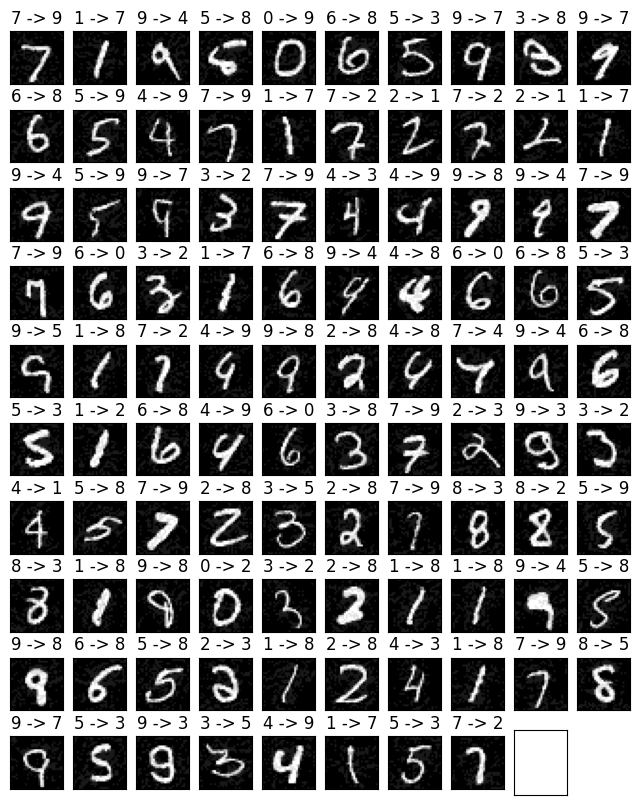

In [8]:
# MNIST Viewer
plt.figure(figsize=(8, 10))
for j in range(100):
    plt.subplot(10, 10, j + 1)
    plt.xticks([], [])
    plt.yticks([], [])
    orig, adv, ex = examples[j]
    plt.title(f"{orig} -> {adv}")
    plt.imshow(ex, cmap="gray")
plt.tight_layout()
plt.show()

In [10]:
# CIFAR10
accuracy, examples = test_pgd(cifar_resnet_model, test_loader_cifar10, 8, 0.05 )
print(accuracy)

Batch: 1, Epsilon: 8, Correct: 0
0/0
0/1
0/3
0/5
0/6
0/7
0/9
0/10
0/11
0/13
0/14
0/15
0/16
0/17
0/18
0/19
0/21
0/23
0/25
0/26
0/27
0/28
0/29
0/30
0/32
0/33
0/34
0/37
0/38
0/39
0/40
0/41
0/43
0/44
0/45
0/46
0/48
0/49
0/50
0/51
0/53
0/54
0/55
0/56
0/60
0/62
0/63
0/64
0/65
0/66
0/67
0/70
0/71
0/72
0/73
0/74
0/75
0/77
0/78
0/79
0/80
0/82
0/83
0/84
0/86
0/88
0/89
0/90
0/92
0/93
0/94
0/95
0/96
0/97
0/98
0/99
0/100
0/101
0/102
0/104
0/105
0/107
0/108
0/109
0/110
0/111
0/113
0/115
0/116
0/117
0/120
0/121
0/122
0/123
0/124
0/126
0/127
0/130
0/131
0/132
0/133
0/134
0/135
0/136
0/137
0/138
0/140
0/141
0/142
0/143
0/144
0/145
0/146
0/149
0/150
0/151
1/152
1/153
1/154
1/155
1/156
1/157
1/159
1/161
1/162
2/163
2/165
2/166
2/167
2/170
2/171
2/173
2/174
2/175
2/176
2/177
2/179
2/180
2/181
2/182
2/183
2/184
2/185
2/186
2/191
2/192
2/193
2/194
2/196
2/197
2/198
2/199
2/200
2/201
2/202
2/203
2/204
2/205
2/206
2/207
2/208
3/209
3/212
3/214
3/215
3/216
3/217
3/219
3/220
3/222
3/223
3/225
3/227
3/231
3/233


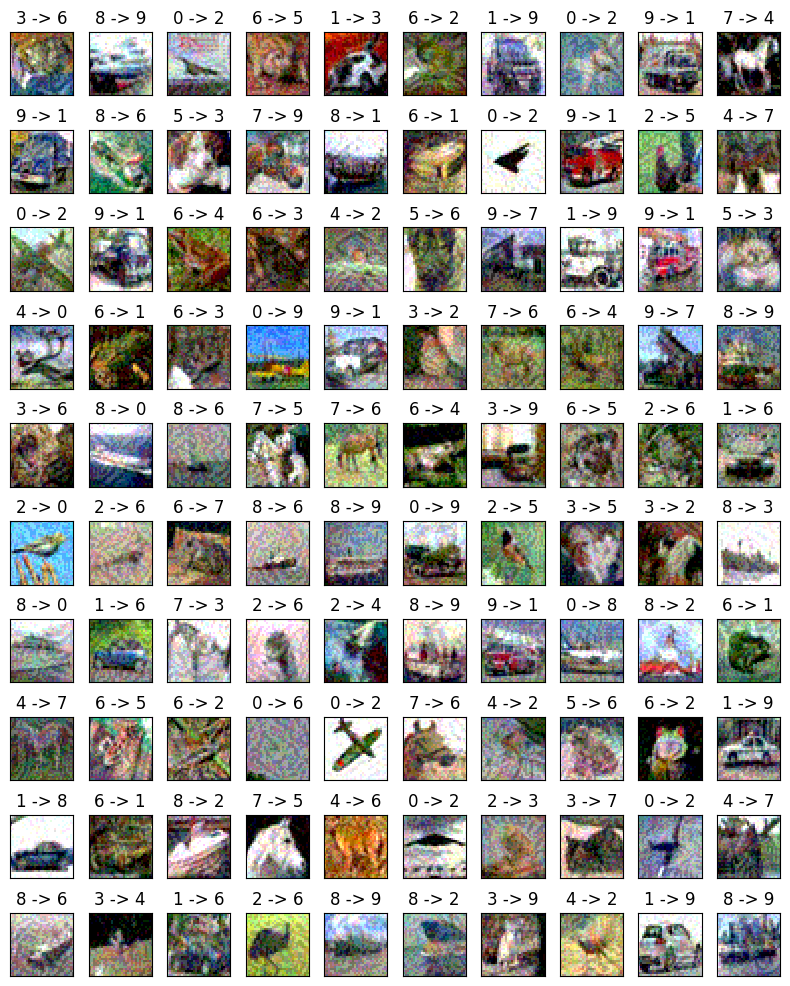

In [11]:
# CIFAR10/SVHN Viewer
plt.figure(figsize=(8, 10))
for j in range(100):
    plt.subplot(10, 10, j + 1)
    plt.xticks([], [])
    plt.yticks([], [])
    orig, adv, ex = examples[j]
    ex = np.transpose(ex, (1, 2, 0))  # Changing shape to (32, 32, 3) for imshow
    # ex = ex / 255.0  # Normalizing pixel values
    plt.title(f"{orig} -> {adv}")
    plt.imshow(ex, cmap="gray")
plt.tight_layout()
plt.show()

In [12]:
# SVHN
accuracy, examples = test_pgd(svhn_resnet_model, test_loader_svhn, 8, 0.05 )
print(accuracy)

Batch: 1, Epsilon: 8, Correct: 0
0/0
0/1
0/2
0/3
0/4
0/5
0/6
0/7
0/8
1/9
1/10
1/11
1/12
1/13
1/14
1/15
1/16
1/17
1/18
1/19
1/20
1/21
1/22
1/24
1/25
1/26
1/27
1/28
1/29
1/31
1/32
1/33
1/34
1/35
1/36
1/37
1/38
1/39
1/41
1/42
1/43
1/44
1/45
1/46
1/47
1/48
1/49
1/50
1/51
1/52
1/53
1/54
1/57
1/60
1/61
1/62
1/63
1/64
1/65
1/66
1/67
1/68
1/69
2/70
2/71
2/72
2/73
2/74
2/75
2/76
2/77
2/78
2/79
2/80
2/81
2/82
2/83
2/84
2/85
2/86
2/87
2/88
2/89
2/90
2/91
3/92
3/93
3/94
4/95
4/97
4/98
4/99
4/100
5/101
6/102
7/103
8/104
8/105
9/106
9/107
9/108
9/109
9/110
9/111
9/112
9/114
9/115
9/116
9/117
9/118
9/119
9/120
9/121
9/122
9/123
9/124
9/125
9/126
9/127
9/128
9/129
9/130
9/132
9/133
9/134
9/135
9/136
9/137
9/138
9/139
9/141
9/142
9/143
9/144
10/145
10/146
10/147
10/148
10/149
10/150
10/151
11/152
11/153
11/154
11/155
11/157
11/158
11/159
11/160
11/161
11/162
11/163
11/164
11/165
11/166
12/167
12/168
12/169
12/170
12/171
12/172
12/173
12/174
12/175
12/176
12/177
12/178
12/179
12/180
12/181
12/182
12/183

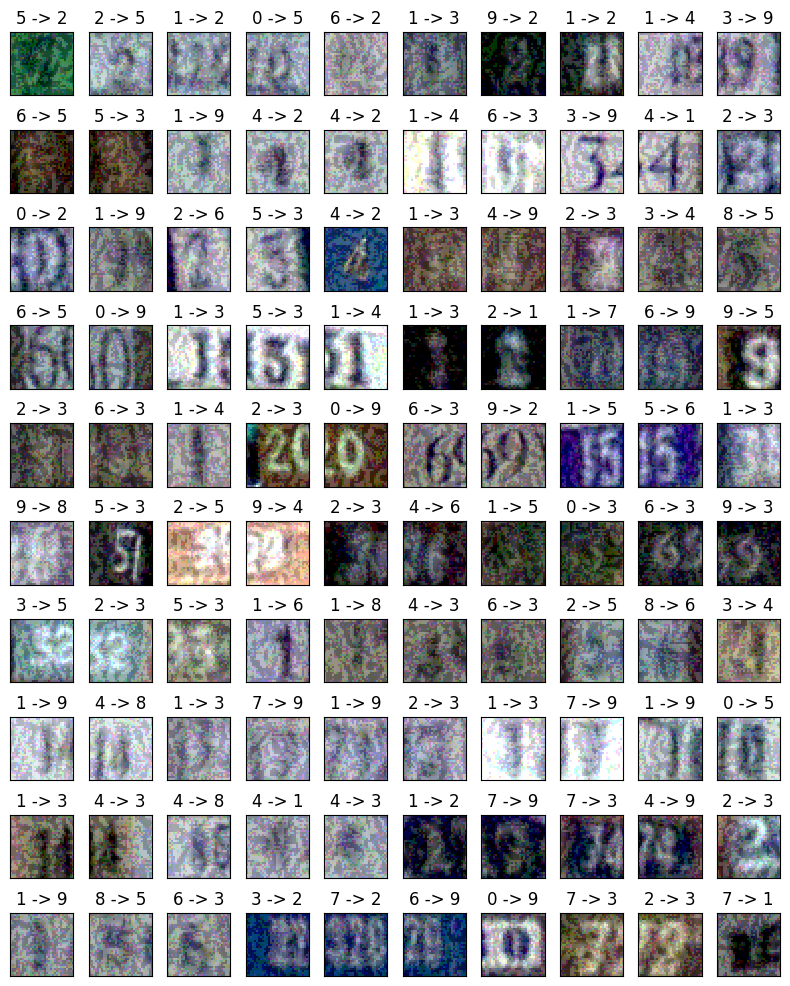

In [13]:
# CIFAR10/SVHN Viewer
plt.figure(figsize=(8, 10))
for j in range(100):
    plt.subplot(10, 10, j + 1)
    plt.xticks([], [])
    plt.yticks([], [])
    orig, adv, ex = examples[j]
    ex = np.transpose(ex, (1, 2, 0))  # Changing shape to (32, 32, 3) for imshow
    # ex = ex / 255.0  # Normalizing pixel values
    plt.title(f"{orig} -> {adv}")
    plt.imshow(ex, cmap="gray")
plt.tight_layout()
plt.show()